In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import os
import numpy as np
import linecache #fast access to a specific file line
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from einops import rearrange, repeat
import torch.nn.functional as F
import time
import torchinfo
from pathlib import Path

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

1.11.0
11.1
True


In [4]:
torch.multiprocessing.set_sharing_strategy('file_system') #to avoid issues in the dataloading
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
CONT_SIZE = 30

In [6]:
ALPHABET = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I",
            "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

ALPHABET = {ALPHABET[i]:i for i in range(len(ALPHABET))}

ALPHABET['-']= 20
ALPHABET['Z']= 21

print(ALPHABET)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, '-': 20, 'Z': 21}


In [7]:
#max 4
rep = torch.tensor([4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4])
rand = torch.tensor([0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0.5, 0.7, 0, 0, 0, 0, 0, 0, 0,0, 0])
#max 8 
rep = torch.tensor([8, 8, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 5, 7, 8, 8, 8, 8, 8])
rand = torch.tensor([0, 0, 0.2, 0, 0, 0, 0, 0, 0.2, 0.5, 0.3, 0.9, 0.8, 0.5, 0.9, 0, 0, 0, 0, 0])

In [8]:
class MyDataset(Dataset):
    def __init__(self, data_dir, cont_size=6,div=2000,verbose=False):
        """
        Initialize the dataset by precomputing a bunch of data on the sequence families
        """
        self.col_size = 60 #number of column per file (Fasta standard)
        self.data_dir = data_dir #directory of the dataset
        self.cont_size = cont_size
        self.div = div
        self.len = 0  #number of families of sequences (1 per file)
        self.paths = {} #path of each families in the folder
        self.seq_lens = {} #length of each member of the family
        self.seq_nums = {} #number of member of the family
        self.aa_freqs = {} #frequencies of each symbol in the sequence family
        self.p_aa_freqs = {} #frequencies of each symbol in each sequence of a family
        
        
        dir_path = data_dir
        count = 0
        
        # Iterate directory
        for path in os.listdir(dir_path):
            # check if current path is a file
            temp_path = os.path.join(dir_path, path)
            if os.path.isfile(temp_path):
                n = 0 #number of sequences
                p = 0 # used to calculate the length of the sequences
                r = 0 # also used this way

                l = 0 # length of the seq l = p * self.col_size + r 

                cpt = 0 # to detect inconsistencies
                
                with open(temp_path, newline='') as f:
                    first_prot = True
                    newf = True
                    
                    aa_freq = torch.zeros(20)
                    p_aa_freq = torch.zeros(0)
                    
                    #parsing the file
                    line = f.readline()[:-1]
                    while line:
                        cpt += 1
                        if line[0] == '>': #header line
                            if not first_prot:
                                p_aa_freq = torch.cat([p_aa_freq,prot_aa_freq])
                            prot_aa_freq = torch.zeros(1,20)
                            n += 1
                            if newf and not first_prot:
                                newf = False
                            first_prot = False
                                
                        else:# sequence line
                            if newf and len(line) == self.col_size:
                                p += 1

                            if newf and len(line) != self.col_size:
                                r = len(line)
                            for aa in line:
                                aa_id = ALPHABET.get(aa,21)
                                if aa_id < 20:
                                    aa_freq[aa_id] += 1
                                    prot_aa_freq[0][aa_id] += 1

                            assert len(line) == self.col_size or len(line) == r
                        line = f.readline()[:-1]
                    
                    p_aa_freq = torch.cat([p_aa_freq,prot_aa_freq])
                    aa_freq = F.normalize(aa_freq,dim=0,p=1)
                    p_aa_freq = F.normalize(p_aa_freq,dim=1,p=1)

                l = p*self.col_size + r
                
                #sanity check
                #if the file line count is coherent with the number of sequences and their line count
                try: #if r != 0
                    assert (p+2) * n == cpt
                except: #if r == 0
                    assert (p+1) * n == cpt
                    assert r == 0
                    
                
                if n>1: #if this is false, we can't find pairs
                    self.paths[count] = path
                    self.seq_lens[count] = l
                    self.seq_nums[count] = n
                    self.aa_freqs[count] = aa_freq
                    self.p_aa_freqs[count] = p_aa_freq
                    count += 1
                    
                    if verbose and (count % 100 ==0) : print(f"seen = {count}")
            
        self.len = count
    
    def __len__(self):
        return self.len
     
    def sample(self, high, low=0, s=1):
        sample = np.random.choice(high-low, s, replace=False)
        return sample + low
    
    def __getitem__(self, idx, sample_size='auto',rep=rep,rand=rand): 
        """
        input idx of the family of the sample
        return a Tensor containing several samples from the family corresponding to the index
        """
        
        X = []
        y = []
        
        PIDs = []
        local_PIDs = []
        
        pfreqs = []
        local_pfreqs = []
        
        lengths = []
        
        pos = []
        
        bin_n = len(rep) #for biasing the sampling
        
        precomputed_pos = [] #positions of the amino-acids
        for i in range(-self.cont_size,self.cont_size+1):
            precomputed_pos.append(i)
        for i in range(-self.cont_size,0):
            precomputed_pos.append(i)
        for i in range(1,self.cont_size+1):
            precomputed_pos.append(i)
        
        precomputed_pos = torch.tensor(precomputed_pos).float()
        
        data_path = os.path.join(self.data_dir, self.paths[idx])
        try:
            n = self.seq_nums[idx]
            l = self.seq_lens[idx]
        except:
            print(idx)
            pass
        
        #sampling more for big families and long sequences
        if type(sample_size) != int:
            sample_s = min(n * l,25_000)
            coef = round((sample_s)/self.div) 
            sample_size = max(1,coef)
        
        p = l // self.col_size
        r = l % self.col_size # l = p * q + r
        sequence_line_count = p+2 if r else p+1

        for _ in range(sample_size):
            i,j = self.sample(n,s=2)

            start_i = 2 + (sequence_line_count)*i #start line of protein i
            start_j = 2 + (sequence_line_count)*j #start line of protein j
            
            seq_i = ''
            seq_j = ''
            
            PID_ij = 0
            
            l_ij = 0
            for offset in range(sequence_line_count-1): #computing PID and removing aligned '-' ##might need to compute the actual column num
                line_i = linecache.getline(data_path, (start_i + offset))[:-1]
                line_j = linecache.getline(data_path, (start_j + offset))[:-1]
                for aa_i, aa_j in zip(line_i,line_j):
                    if aa_i == aa_j:
                        if aa_i != '-':
                            PID_ij += 1
                            seq_i += aa_i
                            seq_j += aa_j        
                    else:
                        seq_i += aa_i
                        seq_j += aa_j
                    
                    if aa_i != '-' and aa_j != '-':
                        l_ij += 1
            
            try:
                PID_ij = PID_ij/l_ij
            except:
                PID_ij = 0 #case 0/0
            
            align_l = len(seq_i)
            possible_k = [] #possible position to take
            for k,(a_i,a_j) in enumerate(zip(seq_i,seq_j)):   
                if ALPHABET.get(a_i,21) < 20 and ALPHABET.get(a_j,21) < 20:
                    possible_k.append(k)
            
            # biasing for more diverse PID  
            bin_idx = int(PID_ij//(1/bin_n))
            rep_number = rep[bin_idx].clone()
            if torch.rand(1) < rand[bin_idx]:
                rep_number+=1
            
            for _ in range(rep_number):
                try:   
                    k = np.random.choice(possible_k)
                except:
                    continue
                
                #adding to the output
                lengths.append(align_l)
                pos_ij = (k + precomputed_pos)
                pos.append(pos_ij)
                
                #computing the windows
                window_i = ''
                window_j = ''
                for w in range(k-self.cont_size,k+self.cont_size+1):
                    if w < 0 or w >= align_l: #case of the edges
                        window_i += 'Z'
                        window_j += 'Z'
                    else:
                        window_i += seq_i[w]
                        window_j += seq_j[w]

                y_j = ALPHABET.get(window_j[self.cont_size], 21) # 'Z' is the default value for rare AA
                X_i = [ALPHABET.get(i, 21) for i in (window_i+window_j[:self.cont_size]+window_j[self.cont_size+1:])]       

                X.append(X_i)
                y.append(y_j)
                PIDs.append(PID_ij)
                #computing the local PID
                local_PID_ij = sum(1 for AA1,AA2 in zip(window_i, window_j[:self.cont_size]) if AA1 == AA2 and ALPHABET.get(AA1,21) < 20) \
                             + sum(1 for AA1,AA2 in zip(reversed(window_i), reversed(window_j[self.cont_size+1:])) if AA1 == AA2 and ALPHABET.get(AA1,21) < 20)

                loc_comp = sum(1 for AA1,AA2 in zip(window_i, window_j[:self.cont_size]) if ALPHABET.get(AA1,21) < 20 and ALPHABET.get(AA2,21) < 20) \
                             + sum(1 for AA1,AA2 in zip(reversed(window_i), reversed(window_j[self.cont_size+1:])) if ALPHABET.get(AA1,21) < 20 and ALPHABET.get(AA2,21) < 20)
                try:
                    tmp = local_PID_ij/loc_comp  
                except:
                    tmp = 0 #case 0/0

                local_PIDs.append(tmp)
                pfreqs.append(self.aa_freqs[idx])
                p_i_freqs = self.p_aa_freqs[idx][i]
                p_j_freqs = self.p_aa_freqs[idx][j]

                local_pfreqs.append(torch.stack((p_i_freqs,p_j_freqs)))

                assert y_j < 20
                assert X_i[self.cont_size] < 20
            
        linecache.clearcache() #clearing the cache
        X = torch.tensor(X)
        try:
            X = F.one_hot(X,22)[:,:,0:-1]
        except RuntimeError:
            pass
        if len(pos) == 0:
            pos = torch.tensor(pos)
        else:
            pos = torch.stack(pos)
        pfreqs = torch.stack(pfreqs)
        local_pfreqs = torch.stack(local_pfreqs)
        X = X.float()
        y = torch.tensor(y)
        PIDs = torch.tensor(PIDs)
        local_PIDs = torch.tensor(local_PIDs)
        lengths = torch.tensor(lengths)
        out = X,y.long(),PIDs,local_PIDs,pfreqs,local_pfreqs,pos,lengths
        return out


In [9]:
#Run This for new data
"""
train_dataset = MyDataset(r"data/train_data",cont_size = 6,4000)
test_dataset = MyDataset(r"data/test_data",cont_size = 6,div=2000)
val_dataset = MyDataset(r"data/val_data",cont_size = 6,div=2000)

fname = 'data/train_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(train_dataset,fp)
    
fname = 'data/test_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(test_dataset,fp)
    
fname = 'data/val_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(val_dataset,fp)
"""

'\ntrain_dataset = MyDataset(r"data/train_data",cont_size = 6,4000)\ntest_dataset = MyDataset(r"data/test_data",cont_size = 6,div=2000)\nval_dataset = MyDataset(r"data/val_data",cont_size = 6,div=2000)\n\nfname = \'data/train_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(train_dataset,fp)\n    \nfname = \'data/test_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(test_dataset,fp)\n    \nfname = \'data/val_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(val_dataset,fp)\n'

In [10]:
#To load datasets with all features computed
fname = 'data/train_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    train_dataset = torch.load(fp)
    
fname = 'data/test_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    test_dataset = torch.load(fp)
    
fname = 'data/val_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    val_dataset = torch.load(fp)
    
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

train_dataset.cont_size = CONT_SIZE
test_dataset.cont_size = CONT_SIZE
val_dataset.cont_size = CONT_SIZE

train_dataset.div = 2000
test_dataset.div = 2000
val_dataset.div = 2000

13219
2838
2826


In [11]:
def my_collate(batch):
    """
    Transforms a list of tensors to a batch tensor
    """
    data = torch.cat([item[0] for item in batch],dim=0)
    target = torch.cat([item[1] for item in batch],dim=0)
    PID = torch.cat([item[2] for item in batch],dim=0)
    lPID = torch.cat([item[3] for item in batch],dim=0)
    pfreqs = torch.cat([item[4] for item in batch],dim=0)
    lpfreqs = torch.cat([item[5] for item in batch],dim=0)
    pos = torch.cat([item[6] for item in batch],dim=0)
    length = torch.cat([item[7] for item in batch],dim=0)
    return data, target, PID, lPID,pfreqs,lpfreqs, pos, length

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

In [13]:
class AttBlock(nn.Module):
    """
    Self-Attention Block of the Transformer
    """
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        out_features = out_features or in_features
        
        self.Q_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.K_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.V_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        
        self.att = nn.MultiheadAttention(num_heads*head_dims,num_heads=num_heads,batch_first=True)
        self.lin = nn.Linear(num_heads*head_dims,out_features)
        
    def forward(self,x):
        Q = self.Q_w(x)
        K = self.K_w(x)
        V = self.V_w(x)
        out,_ = self.att(Q,K,V,need_weights=False)
        out = self.lin(out)
        
        return out

In [14]:
class CrossAttBlock(nn.Module):
    """
    Cross-Attention Block of the Transformer
    """
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        out_features = out_features or in_features
        
        self.Q_w_src = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.K_w_src = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.V_w_src = nn.Linear(in_features,num_heads*head_dims,bias=False)
        
        self.Q_w_tgt = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.K_w_tgt = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.V_w_tgt = nn.Linear(in_features,num_heads*head_dims,bias=False)
        
        self.att_tgt = nn.MultiheadAttention(num_heads*head_dims,num_heads=num_heads,batch_first=True)
        self.att_src = nn.MultiheadAttention(num_heads*head_dims,num_heads=num_heads,batch_first=True)
        self.lin = nn.Linear(num_heads*head_dims,out_features)
        
    def forward(self,x):
        src,tgt = x[:,0],x[:,1]
        Q_tgt = self.Q_w_tgt(tgt)
        K_tgt = self.K_w_tgt(tgt)
        V_tgt = self.V_w_tgt(tgt)
        
        Q_src = self.V_w_src(src)
        K_src = self.K_w_src(src)
        V_src = self.V_w_src(src)
        
        out_src,_ = self.att_src(Q_src,K_tgt,V_tgt,need_weights=False)
        out_tgt,_ = self.att_tgt(Q_tgt,K_src,V_src,need_weights=False)
        
        out = torch.stack((out_src,out_tgt),dim=1)
        out = self.lin(out)
        
        return out

In [15]:
class LastCrossAttBlock(nn.Module):
    """
    Cross-Attention Block of the Transformer
    """
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        out_features = out_features or in_features
        
        self.Q_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.K_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.V_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        
        self.att = nn.MultiheadAttention(num_heads*head_dims,num_heads=num_heads,batch_first=True)
        self.lin = nn.Linear(num_heads*head_dims,out_features)
        
    def forward(self,x):
        src,tgt = x[:,0],x[:,1]
        Q = self.Q_w(tgt)
        K = self.K_w(src)
        V = self.V_w(src)
        out,_ = self.att(Q,K,V,need_weights=False)
        out = self.lin(out)
        
        return out

In [16]:
class RowAttBlock(nn.Module):
    """
    Row-wise Attention Block
    """
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        self.att_block = AttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
    
    def forward(self,x):
        b,n,l,d = x.shape
        out = self.att_block(x.view((b*n,l,d))).view(b,n,l,d)
        return out
    
class ColAttBlock(nn.Module):
    """
    Column-wise Attention Block
    """
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        self.att_block = AttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
    
    def forward(self,x):
        b,n,l,d = x.shape
        out = self.att_block(x.view((b*l,n,d))).view((b,n,l,d))
        return out

In [17]:
class FeedFoward2D(nn.Module):
    """
    MLP Block of the Transformer
    """    
    def __init__(self,in_features,out_features=None,wide_factor=4):
        super().__init__()
        out_features = out_features or 2*in_features
        hidden_dim = wide_factor * 2*in_features
        
        self.lin1 = nn.Linear(2*in_features,hidden_dim)
        self.act1 = nn.GELU()
        self.lin2 = nn.Linear(hidden_dim,out_features)
        self.act2 = nn.GELU()
        
    def forward(self,x):
        b,n,l,d = x.shape
        out = x.view(b,l,n*d)
        out = self.lin1(out)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        return out.view(b,n,l,d)

In [18]:
class FeedFoward(nn.Module):
    """
    MLP Block of the Transformer
    """    
    def __init__(self,in_features,out_features=None,wide_factor=4):
        super().__init__()
        out_features = out_features or in_features
        hidden_dim = wide_factor * in_features
        
        self.lin1 = nn.Linear(in_features,hidden_dim)
        self.act1 = nn.GELU()
        self.lin2 = nn.Linear(hidden_dim,out_features)
        self.act2 = nn.GELU()
        
    def forward(self,x):
        out = self.lin1(x)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        
        return out

In [19]:
#(from the timm library)
def drop_path(x, drop_prob: float = 0.1, training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None, scale_by_keep=True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)


In [20]:
class Block(nn.Module):
    """
    Basic Block of the Transformer
    """
    def __init__(self,in_features,num_heads=8,head_dims=24,wide_factor=4,drop=0.1):
        super().__init__()
        
        self.row_att_block = RowAttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
        self.ff2d = FeedFoward2D(in_features,wide_factor=wide_factor)
        self.drop_path = DropPath(drop)
        
        self.norm1 = nn.LayerNorm(in_features)
        self.norm2 = nn.LayerNorm(in_features)
    def forward(self,x):
        out = x + self.drop_path(self.row_att_block(x))
        out = self.norm1(out)
        out = out + self.drop_path(self.ff2d(out))
        out = self.norm2(out)
        return out

In [21]:
class LastBlock(nn.Module):
    """
    Last Block of the Transformer
    """
    def __init__(self,in_features,num_heads=8,head_dims=24,wide_factor=4,drop=0.1):
        super().__init__()
        
        self.cross_att_block = LastCrossAttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
        self.ff = FeedFoward(in_features,wide_factor=wide_factor)
        self.drop_path = DropPath(drop)
        
        self.norm1 = nn.LayerNorm(in_features)
        self.norm2 = nn.LayerNorm(in_features)
    def forward(self,x):
        out = x[:,1] + self.drop_path(self.cross_att_block(x))
        out = self.norm1(out)
        out = out + self.drop_path(self.ff(out))
        out = self.norm2(out)
        return out

ADD Linear + Act d-wise before clf_head

In [22]:
class Classifier_Head(nn.Module):
    """
    Classifier Head of the Transformer
    """
    def __init__(self,in_features,clf_dims,out_size,seq_len):
        super().__init__()
        in_dim = seq_len*in_features
        self.in_dim = in_dim
        
        layers = []
        for out_dim in clf_dims:
            layers.append(nn.Linear(in_dim,out_dim))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(p=0.2))
            in_dim = out_dim

        layers.append(nn.Linear(in_dim,out_size))
        
        self.clf = nn.Sequential(*layers)
        
    def forward(self,x):
        out = x.view((-1,self.in_dim))
        
        out = self.clf(out)
        
        return out

In [23]:
def get_params(input_size,N,head,head_dim,wide_factor,drop_prob):
    """
    Returns the initialization parameters of the Transformer
    """
    return input_size, [head for _ in range(N)], [head_dim for _ in range(N)], [wide_factor for _ in range(N)], [drop_prob for _ in range(N)], 

In [24]:
class AttNet(nn.Module):
    """
    Transformer-like neural net
    """
    def __init__(self,in_features,num_heads,head_dims,wide_factors,drops,input_dim=21,out_size=20,num_seq=2,seq_len=2*CONT_SIZE+4,clf_dims=[256,64],cont_size=CONT_SIZE):
        super().__init__()
        self.in_features = in_features
        self.input_dim = input_dim
        self.cont_size=cont_size
        
        blocks = []
        r = min(len(num_heads),len(head_dims),len(wide_factors),len(drops))
        for i,(n_h, h_d,w,d) in enumerate(zip(num_heads,head_dims,wide_factors,drops)):
            if i < (r-1):
                blocks.append(Block(in_features,num_heads=n_h,head_dims=h_d,wide_factor=w,drop=d))
            else:
                blocks.append(LastBlock(in_features,num_heads=n_h,head_dims=h_d,wide_factor=w,drop=d))
        self.feature_extractor = nn.Sequential(*blocks)
        
        self.clf = Classifier_Head(in_features,clf_dims,out_size=out_size,seq_len=seq_len)
        
        sp = Path("data/freq.pth")
        with sp.open("rb") as fp:
            self.F = nn.Parameter(torch.log(torch.load(fp)))
            
        pid_layers = [nn.Linear(1,2*in_features),nn.Sigmoid()]
        self.pid_l = nn.Sequential(*pid_layers)
        
    def to_input(self,x,PID,pfreqs,lpfreqs,pos,length):
        X_idx = torch.argmax(x[:,self.cont_size],dim=1)
        seq1 = x[:,:2*self.cont_size+1]
        y_freq = F.pad(F.softmax(self.F[X_idx],dim=1).unsqueeze(1), pad=(0, 1), mode='constant', value=0) 
        seq2 = torch.cat((x[:,2*self.cont_size+1:3*self.cont_size+1],y_freq,x[:,3*self.cont_size+1:]),dim=1)
        aa_pos = pos[:,:2*self.cont_size+1]/length.unsqueeze(1)
        aa_pos = aa_pos.unsqueeze(2)
        pos_dim = (self.in_features-self.input_dim-1)//2
        
        for i in range(pos_dim): #positionnal_encoding
            p = torch.cos(pos[:,:2*self.cont_size+1]/(4**(2*i/pos_dim))).unsqueeze(2)
            ip = torch.sin(pos[:,:2*self.cont_size+1]/(4**(2*i/pos_dim))).unsqueeze(2)
            aa_pos = torch.cat([aa_pos,p,ip],dim=2)
        
        seq1 = torch.cat([seq1,aa_pos],dim=2)
        seq2 = torch.cat([seq2,aa_pos],dim=2)
        
        out = torch.stack([seq1,seq2],dim=1)
        
        pad = (0,self.in_features-self.input_dim+1)
        pf = F.pad(pfreqs.unsqueeze(1),pad =pad, mode='constant', value=0)
        pf = repeat(pf,"b 1 d -> b 2 1 d")
        
        pid = self.pid_l(PID.unsqueeze(1)).unsqueeze(1)
        pid = rearrange(pid,"b 1 (n e) -> b n 1 e",n=2)
        
        lpf = F.pad(lpfreqs,pad=pad, mode='constant', value=0).unsqueeze(2)
        out = torch.cat([out,pf,pid,lpf],dim=2)
        
        return out
        
        
    def forward(self,x,PID,pfreqs,lpfreqs,pos,length):
        X_input = self.to_input(x,PID,pfreqs,lpfreqs,pos,length)
        features = self.feature_extractor(X_input)
        out = self.clf(features)
        return out

In [25]:
class State:
    """
    Used for checkpointing
    """
    def __init__(self,model,optim,scheduler):
        self.model = model
        self.optim = optim
        self.scheduler = scheduler
        self.epoch = 0

In [96]:
params = get_params(32,6,8,32,4,0.1)
model = AttNet(*params,clf_dims=[512,128,32])
torchinfo.summary(model,[(1,4*CONT_SIZE+1,21),(1,),(1,20),(1,2,20),(1,4*CONT_SIZE+1),(1,)])

Layer (type:depth-idx)                             Output Shape              Param #
AttNet                                             [1, 20]                   400
├─Sequential: 1-1                                  [1, 64]                   --
│    └─Linear: 2-1                                 [1, 64]                   128
│    └─Sigmoid: 2-2                                [1, 64]                   --
├─Sequential: 1-2                                  [1, 64, 32]               --
│    └─Block: 2-3                                  [1, 2, 64, 32]            --
│    │    └─RowAttBlock: 3-1                       [1, 2, 64, 32]            295,968
│    │    └─DropPath: 3-2                          [1, 2, 64, 32]            --
│    │    └─LayerNorm: 3-3                         [1, 2, 64, 32]            64
│    │    └─FeedFoward2D: 3-4                      [1, 2, 64, 32]            33,088
│    │    └─DropPath: 3-5                          [1, 2, 64, 32]            --
│    │    └─LayerNorm: 3

In [26]:
def eval_model(fname,train,test,val,N=10):
    """
    Evaluate the MSE (Brier Score) of the model
    """
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
        
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())

        score_train = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_train = }\n")

        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs, pos,length in test:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
        score_test = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_test = }\n")

        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs, pos, length in val:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                lPID = lPID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
        score_val = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_val = }\n")
    
    return score_train, score_test, score_val

In [27]:
def eval_model_PID(fname,train,test,val,N=10):
    """
    Evaluate the MSE (Brier Score) of the model for different slices of PID in the data
    """
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
    bin_n = 20
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_train = torch.zeros(bin_n)
        bar_train = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_train[i] += 1
            Losses_train[i] += n
        Losses_train = Losses_train/bar_train
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_train,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Train dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_train,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Train dataset")
        plt.show()
        
        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in test:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_test = torch.zeros(bin_n)
        bar_test = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_test[i] += 1
            Losses_test[i] += n
        Losses_test = Losses_test/bar_test
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_test,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Test dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_test,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Test dataset")
        plt.show()
        
        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in val:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_val = torch.zeros(bin_n)
        bar_val = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_val[i] += 1
            Losses_val[i] += n
        Losses_val = Losses_val/bar_val
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_val,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Val dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_val,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Val dataset")
        plt.show()
        
    return Losses_train, bar_train, Losses_test, bar_test, Losses_val,bar_val

In [28]:
def eval_model_acc_PID(fname,train,test,val,N=10):
    """
    Evaluate the accuracy of the model for different slices of PID in the data
    """
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
    bin_n = 20
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = torch.argmax(y_hat,dim=1)

                eval_l = (y == y_hat).long()
                eval_losses.append(eval_l.detach().cpu())
                
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_train = torch.zeros(bin_n)
        bar_train = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_train[i] += 1
            Losses_train[i] += n
        Losses_train = Losses_train/bar_train
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_train,width=1/(bin_n+1))
        plt.title("Accuracy wrt PID on Train dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_train,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Train dataset")
        plt.show()
        
        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in test:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = torch.argmax(y_hat,dim=1)

                eval_l = (y == y_hat).long()
                eval_losses.append(eval_l.detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_test = torch.zeros(bin_n)
        bar_test = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_test[i] += 1
            Losses_test[i] += n
        Losses_test = Losses_test/bar_test
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_test,width=1/(bin_n+1))
        plt.title("Accuracy wrt PID on Test dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_test,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Test dataset")
        plt.show()
        
        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in val:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = torch.argmax(y_hat,dim=1)

                eval_l = (y == y_hat).long()
                eval_losses.append(eval_l.detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_val = torch.zeros(bin_n)
        bar_val = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_val[i] += 1
            Losses_val[i] += n
        Losses_val = Losses_val/bar_val
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_val,width=1/(bin_n+1))
        plt.title("Accuracy wrt PID on Val dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_val,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Val dataset")
        plt.show()
        
    return Losses_train, bar_train, Losses_test, bar_test, Losses_val,bar_val

In [29]:
def main(train_loader,val_loader,epochs=101,fname="models/state.pth",fnameb=None,state=None,last_epoch_sched=float('inf'),use_mut=True,cont_size=CONT_SIZE):
    """
    Trains a model
    """
    #to get the best model
    best = float('inf')
    
    #getting the acceleration device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    #loading from previous checkpoint
    if fnameb is None:
        fnameb = fname[:-4] + '_best' +fname[-4:]
        
    savepath = Path(fname)
    if savepath.is_file():
        with savepath.open("rb") as fp:
            state = torch.load(fp)
    else:
        if state is None:
            model = AttNet(22,[8,8,8],[24,24,24],[4,4,4],[0.1,0.1,0.1])
            model = model.to(device)
            optim = torch.optim.AdamW(model.parameters(),lr = 0.0001)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,16,2)
            state = State(model,optim,scheduler)
    
    
    Loss = nn.CrossEntropyLoss(reduction='sum')
    LossMut = nn.BCELoss(reduction='sum')
    EvalLoss = nn.MSELoss(reduction='mean')
    
    #for logs
    List_Loss = []
    Eval_Loss = []
    for epoch in range(state.epoch, epochs):
        batch_losses = []
        state.model.train()
        for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train_loader:
            X = X.to(device)
            y = y.to(device)
            PID = PID.to(device)
            pos = pos.to(device)
            pfreqs = pfreqs.to(device)
            lpfreqs = lpfreqs.to(device)
            length = length.to(device)
            
            state.optim.zero_grad()
            y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
            

            if use_mut:
                X_idx = torch.argmax(X[:,cont_size],dim=1)
                y_true = (X_idx == y).float().unsqueeze(1)  #0 if a mutation happens else 1 
                y_pred = F.softmax(y_hat,dim=1)
                y_pred = y_pred.gather(1,X_idx.view(-1,1)) #the Xth component of y_hat should be predicting ^
                l = (Loss(y_hat,y) + LossMut(y_pred,y_true))/440 
            else:
                l = Loss(y_hat,y)/440 
            l.backward()
            state.optim.step()
            
            
            
            batch_losses.append(l.detach().cpu())
        List_Loss.append(torch.mean(torch.stack(batch_losses)).detach().cpu())
        state.epoch = epoch + 1
        if epoch < last_epoch_sched:
            state.scheduler.step()
        
        savepath = Path(fname)
        with savepath.open("wb") as fp:
            torch.save(state,fp)
        
        with torch.no_grad():
            eval_losses = [] 
            state.model.eval()
            for X,y, PID, lPID,pfreqs,lpfreqs, pos,length in val_loader:

                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
            score = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
            Eval_Loss.append(score)
        
        if score < best :
            best = score
            savepath = Path(fnameb)
            with savepath.open("wb") as fp:
                torch.save(state,fp)
        
        print(f"epoch n°{epoch} : train_loss = {List_Loss[-1]}, val_loss = {Eval_Loss[-1]}") 


        
    return List_Loss,Eval_Loss,state

In [102]:
params = get_params(32,6,8,32,4,0.1)
model = AttNet(*params,clf_dims=[512,128,32])
model = model.to(device)
optim = torch.optim.AdamW(model.parameters(),lr = 0.0003)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,16,2)
state = State(model,optim,scheduler)

fname = "models/state_6L_RowAtt.pth" 
start = time.time()
Train,Eval,_ = main(train_dataloader, val_dataloader,fname=fname,epochs=4080,state=state,use_mut=False)
stop = time.time()
print(stop-start)

epoch n°0 : train_loss = 2.9186041355133057, val_loss = 0.9230366349220276
epoch n°1 : train_loss = 2.640645980834961, val_loss = 0.8287420868873596
epoch n°2 : train_loss = 2.352224111557007, val_loss = 0.776576578617096
epoch n°3 : train_loss = 2.2427148818969727, val_loss = 0.750948429107666
epoch n°4 : train_loss = 2.1907620429992676, val_loss = 0.7304750084877014
epoch n°5 : train_loss = 2.184174060821533, val_loss = 0.7358975410461426
epoch n°6 : train_loss = 2.152860164642334, val_loss = 0.7205376625061035
epoch n°7 : train_loss = 2.151711940765381, val_loss = 0.7293621897697449
epoch n°8 : train_loss = 2.1365983486175537, val_loss = 0.7173852324485779
epoch n°9 : train_loss = 2.135282039642334, val_loss = 0.7287202477455139
epoch n°10 : train_loss = 2.1234426498413086, val_loss = 0.7210492491722107
epoch n°11 : train_loss = 2.1146137714385986, val_loss = 0.7255620956420898
epoch n°12 : train_loss = 2.1237502098083496, val_loss = 0.717576801776886
epoch n°13 : train_loss = 2.118

epoch n°109 : train_loss = 1.9466495513916016, val_loss = 0.6738174557685852
epoch n°110 : train_loss = 1.9551262855529785, val_loss = 0.6721101999282837
epoch n°111 : train_loss = 1.9506980180740356, val_loss = 0.6692436933517456
epoch n°112 : train_loss = 1.9984670877456665, val_loss = 0.6844195127487183
epoch n°113 : train_loss = 1.9810580015182495, val_loss = 0.6897282004356384
epoch n°114 : train_loss = 2.0011744499206543, val_loss = 0.6861112117767334
epoch n°115 : train_loss = 1.9906766414642334, val_loss = 0.6850007772445679
epoch n°116 : train_loss = 1.9838731288909912, val_loss = 0.6812973618507385
epoch n°117 : train_loss = 1.9829723834991455, val_loss = 0.678375780582428
epoch n°118 : train_loss = 1.9823850393295288, val_loss = 0.676567554473877
epoch n°119 : train_loss = 1.9853341579437256, val_loss = 0.6812220811843872
epoch n°120 : train_loss = 1.9942494630813599, val_loss = 0.6754170656204224
epoch n°121 : train_loss = 1.9757829904556274, val_loss = 0.6834009885787964
e

epoch n°216 : train_loss = 1.9069184064865112, val_loss = 0.6609503626823425
epoch n°217 : train_loss = 1.903403878211975, val_loss = 0.6608176827430725
epoch n°218 : train_loss = 1.895513892173767, val_loss = 0.6687406301498413
epoch n°219 : train_loss = 1.9122029542922974, val_loss = 0.6645704507827759
epoch n°220 : train_loss = 1.8982194662094116, val_loss = 0.663131594657898
epoch n°221 : train_loss = 1.9036554098129272, val_loss = 0.6648126840591431
epoch n°222 : train_loss = 1.9036784172058105, val_loss = 0.6660487651824951
epoch n°223 : train_loss = 1.8901679515838623, val_loss = 0.6607059240341187
epoch n°224 : train_loss = 1.900294303894043, val_loss = 0.66743004322052
epoch n°225 : train_loss = 1.8963814973831177, val_loss = 0.6647383570671082
epoch n°226 : train_loss = 1.9073039293289185, val_loss = 0.6592505574226379
epoch n°227 : train_loss = 1.9005006551742554, val_loss = 0.6663726568222046
epoch n°228 : train_loss = 1.8991249799728394, val_loss = 0.6569676995277405
epoch

epoch n°324 : train_loss = 1.90923011302948, val_loss = 0.6680436730384827
epoch n°325 : train_loss = 1.911473035812378, val_loss = 0.6714333891868591
epoch n°326 : train_loss = 1.9064781665802002, val_loss = 0.6614366769790649
epoch n°327 : train_loss = 1.9039324522018433, val_loss = 0.6678575873374939
epoch n°328 : train_loss = 1.9052268266677856, val_loss = 0.6583002805709839
epoch n°329 : train_loss = 1.9041165113449097, val_loss = 0.6625199913978577
epoch n°330 : train_loss = 1.911625623703003, val_loss = 0.6597970128059387
epoch n°331 : train_loss = 1.9109845161437988, val_loss = 0.6637067794799805
epoch n°332 : train_loss = 1.900060772895813, val_loss = 0.6644062995910645
epoch n°333 : train_loss = 1.910286545753479, val_loss = 0.6627314686775208
epoch n°334 : train_loss = 1.8946439027786255, val_loss = 0.6637871861457825
epoch n°335 : train_loss = 1.9015785455703735, val_loss = 0.6640554666519165
epoch n°336 : train_loss = 1.8989722728729248, val_loss = 0.6532382965087891
epoch

epoch n°431 : train_loss = 1.8719290494918823, val_loss = 0.6635724902153015
epoch n°432 : train_loss = 1.8765586614608765, val_loss = 0.6611565947532654
epoch n°433 : train_loss = 1.882164716720581, val_loss = 0.6614034175872803
epoch n°434 : train_loss = 1.8822615146636963, val_loss = 0.663384199142456
epoch n°435 : train_loss = 1.8705579042434692, val_loss = 0.6579512357711792
epoch n°436 : train_loss = 1.8802297115325928, val_loss = 0.661502480506897
epoch n°437 : train_loss = 1.872225284576416, val_loss = 0.6541939377784729
epoch n°438 : train_loss = 1.8741799592971802, val_loss = 0.6606897115707397
epoch n°439 : train_loss = 1.8715529441833496, val_loss = 0.6620053052902222
epoch n°440 : train_loss = 1.879358172416687, val_loss = 0.6617940664291382
epoch n°441 : train_loss = 1.8890215158462524, val_loss = 0.6614766716957092
epoch n°442 : train_loss = 1.880260705947876, val_loss = 0.6549001336097717
epoch n°443 : train_loss = 1.87075674533844, val_loss = 0.6617348194122314
epoch n

epoch n°538 : train_loss = 1.89732027053833, val_loss = 0.6609851121902466
epoch n°539 : train_loss = 1.8991245031356812, val_loss = 0.6632573008537292
epoch n°540 : train_loss = 1.8912203311920166, val_loss = 0.6714739799499512
epoch n°541 : train_loss = 1.8923957347869873, val_loss = 0.6599876880645752
epoch n°542 : train_loss = 1.8964576721191406, val_loss = 0.6629606485366821
epoch n°543 : train_loss = 1.8895076513290405, val_loss = 0.6706521511077881
epoch n°544 : train_loss = 1.8951034545898438, val_loss = 0.6626340746879578
epoch n°545 : train_loss = 1.8978533744812012, val_loss = 0.664742648601532
epoch n°546 : train_loss = 1.8947833776474, val_loss = 0.6632899641990662
epoch n°547 : train_loss = 1.880002498626709, val_loss = 0.6645791530609131
epoch n°548 : train_loss = 1.9019505977630615, val_loss = 0.6563186645507812
epoch n°549 : train_loss = 1.9047826528549194, val_loss = 0.6676831245422363
epoch n°550 : train_loss = 1.9028277397155762, val_loss = 0.662588894367218
epoch n

epoch n°645 : train_loss = 1.879045009613037, val_loss = 0.6593523025512695
epoch n°646 : train_loss = 1.8856792449951172, val_loss = 0.6624943017959595
epoch n°647 : train_loss = 1.8782564401626587, val_loss = 0.6626660227775574
epoch n°648 : train_loss = 1.877456545829773, val_loss = 0.6627262830734253
epoch n°649 : train_loss = 1.880973219871521, val_loss = 0.6571997404098511
epoch n°650 : train_loss = 1.8709068298339844, val_loss = 0.6610618829727173
epoch n°651 : train_loss = 1.863014578819275, val_loss = 0.6578975915908813
epoch n°652 : train_loss = 1.873541235923767, val_loss = 0.6594787240028381
epoch n°653 : train_loss = 1.8764232397079468, val_loss = 0.6600220799446106
epoch n°654 : train_loss = 1.8850363492965698, val_loss = 0.6573988199234009
epoch n°655 : train_loss = 1.880157470703125, val_loss = 0.6629298329353333
epoch n°656 : train_loss = 1.8642473220825195, val_loss = 0.6635800004005432
epoch n°657 : train_loss = 1.8719799518585205, val_loss = 0.6618987917900085
epoch

epoch n°752 : train_loss = 1.858101487159729, val_loss = 0.6524773240089417
epoch n°753 : train_loss = 1.8653234243392944, val_loss = 0.6517190337181091
epoch n°754 : train_loss = 1.8551543951034546, val_loss = 0.6591718196868896
epoch n°755 : train_loss = 1.8529306650161743, val_loss = 0.651626706123352
epoch n°756 : train_loss = 1.8600603342056274, val_loss = 0.660102367401123
epoch n°757 : train_loss = 1.8539819717407227, val_loss = 0.6573330163955688
epoch n°758 : train_loss = 1.8613089323043823, val_loss = 0.6529894471168518
epoch n°759 : train_loss = 1.858583927154541, val_loss = 0.6542694568634033
epoch n°760 : train_loss = 1.8523409366607666, val_loss = 0.650171160697937
epoch n°761 : train_loss = 1.8602112531661987, val_loss = 0.6593953371047974
epoch n°762 : train_loss = 1.8548928499221802, val_loss = 0.6500325202941895
epoch n°763 : train_loss = 1.857822299003601, val_loss = 0.6512860655784607
epoch n°764 : train_loss = 1.8545570373535156, val_loss = 0.662151575088501
epoch 

epoch n°860 : train_loss = 1.856923222541809, val_loss = 0.6505481600761414
epoch n°861 : train_loss = 1.8534579277038574, val_loss = 0.652330219745636
epoch n°862 : train_loss = 1.8404278755187988, val_loss = 0.6556342840194702
epoch n°863 : train_loss = 1.8447097539901733, val_loss = 0.6605399250984192
epoch n°864 : train_loss = 1.855908989906311, val_loss = 0.6542324423789978
epoch n°865 : train_loss = 1.8519083261489868, val_loss = 0.6502560973167419
epoch n°866 : train_loss = 1.8391737937927246, val_loss = 0.6543205380439758
epoch n°867 : train_loss = 1.842278242111206, val_loss = 0.6503475308418274
epoch n°868 : train_loss = 1.8563401699066162, val_loss = 0.6574357151985168
epoch n°869 : train_loss = 1.8413017988204956, val_loss = 0.6550651788711548
epoch n°870 : train_loss = 1.8452372550964355, val_loss = 0.6520472764968872
epoch n°871 : train_loss = 1.8507763147354126, val_loss = 0.6476230025291443
epoch n°872 : train_loss = 1.8511534929275513, val_loss = 0.6521371006965637
epo

epoch n°967 : train_loss = 1.8502171039581299, val_loss = 0.6489706635475159
epoch n°968 : train_loss = 1.8527519702911377, val_loss = 0.6527978181838989
epoch n°969 : train_loss = 1.8262122869491577, val_loss = 0.6525658965110779
epoch n°970 : train_loss = 1.835876703262329, val_loss = 0.6465084552764893
epoch n°971 : train_loss = 1.8487176895141602, val_loss = 0.6487672924995422
epoch n°972 : train_loss = 1.846975564956665, val_loss = 0.6486813426017761
epoch n°973 : train_loss = 1.8345855474472046, val_loss = 0.6568856835365295
epoch n°974 : train_loss = 1.8411788940429688, val_loss = 0.6532842516899109
epoch n°975 : train_loss = 1.8463183641433716, val_loss = 0.6520555019378662
epoch n°976 : train_loss = 1.847515344619751, val_loss = 0.65818852186203
epoch n°977 : train_loss = 1.84722900390625, val_loss = 0.6542806029319763
epoch n°978 : train_loss = 1.8428317308425903, val_loss = 0.6481146216392517
epoch n°979 : train_loss = 1.8465708494186401, val_loss = 0.6502206325531006
epoch 

epoch n°1074 : train_loss = 1.863007664680481, val_loss = 0.6489794850349426
epoch n°1075 : train_loss = 1.8670110702514648, val_loss = 0.6552784442901611
epoch n°1076 : train_loss = 1.8656054735183716, val_loss = 0.6602650880813599
epoch n°1077 : train_loss = 1.8638907670974731, val_loss = 0.6653596758842468
epoch n°1078 : train_loss = 1.8646010160446167, val_loss = 0.6527109146118164
epoch n°1079 : train_loss = 1.882694959640503, val_loss = 0.6542685627937317
epoch n°1080 : train_loss = 1.869795799255371, val_loss = 0.649132251739502
epoch n°1081 : train_loss = 1.861656904220581, val_loss = 0.6558293700218201
epoch n°1082 : train_loss = 1.861769676208496, val_loss = 0.6532142162322998
epoch n°1083 : train_loss = 1.8659961223602295, val_loss = 0.6606284976005554
epoch n°1084 : train_loss = 1.8628880977630615, val_loss = 0.6527474522590637
epoch n°1085 : train_loss = 1.8635038137435913, val_loss = 0.6572226285934448
epoch n°1086 : train_loss = 1.866434931755066, val_loss = 0.6606340408

epoch n°1180 : train_loss = 1.8624677658081055, val_loss = 0.6547358632087708
epoch n°1181 : train_loss = 1.8702282905578613, val_loss = 0.6557314991950989
epoch n°1182 : train_loss = 1.851578712463379, val_loss = 0.6573798656463623
epoch n°1183 : train_loss = 1.8522512912750244, val_loss = 0.6539053320884705
epoch n°1184 : train_loss = 1.856676459312439, val_loss = 0.6513338685035706
epoch n°1185 : train_loss = 1.8741055727005005, val_loss = 0.6537489891052246
epoch n°1186 : train_loss = 1.863484263420105, val_loss = 0.6513529419898987
epoch n°1187 : train_loss = 1.8627032041549683, val_loss = 0.6602997183799744
epoch n°1188 : train_loss = 1.8617886304855347, val_loss = 0.6557794213294983
epoch n°1189 : train_loss = 1.8624284267425537, val_loss = 0.654784083366394
epoch n°1190 : train_loss = 1.860538363456726, val_loss = 0.6604419946670532
epoch n°1191 : train_loss = 1.8533997535705566, val_loss = 0.658387303352356
epoch n°1192 : train_loss = 1.8600741624832153, val_loss = 0.656516015

epoch n°1286 : train_loss = 1.8512187004089355, val_loss = 0.6554930210113525
epoch n°1287 : train_loss = 1.852260708808899, val_loss = 0.6566260457038879
epoch n°1288 : train_loss = 1.8554126024246216, val_loss = 0.6550557613372803
epoch n°1289 : train_loss = 1.8554800748825073, val_loss = 0.6578508615493774
epoch n°1290 : train_loss = 1.846291184425354, val_loss = 0.6503267884254456
epoch n°1291 : train_loss = 1.8442400693893433, val_loss = 0.6539472341537476
epoch n°1292 : train_loss = 1.8552132844924927, val_loss = 0.650581955909729
epoch n°1293 : train_loss = 1.8472808599472046, val_loss = 0.6524578332901001
epoch n°1294 : train_loss = 1.862900733947754, val_loss = 0.6558663845062256
epoch n°1295 : train_loss = 1.8475499153137207, val_loss = 0.6558583378791809
epoch n°1296 : train_loss = 1.8572442531585693, val_loss = 0.6575080156326294
epoch n°1297 : train_loss = 1.8580427169799805, val_loss = 0.6598822474479675
epoch n°1298 : train_loss = 1.84781813621521, val_loss = 0.653662085

epoch n°1392 : train_loss = 1.8424054384231567, val_loss = 0.6561189889907837
epoch n°1393 : train_loss = 1.8489913940429688, val_loss = 0.6580629944801331
epoch n°1394 : train_loss = 1.8444703817367554, val_loss = 0.6561889052391052
epoch n°1395 : train_loss = 1.8508256673812866, val_loss = 0.654755711555481
epoch n°1396 : train_loss = 1.853657603263855, val_loss = 0.6507812738418579
epoch n°1397 : train_loss = 1.8437339067459106, val_loss = 0.6509926319122314
epoch n°1398 : train_loss = 1.848536491394043, val_loss = 0.6477342247962952
epoch n°1399 : train_loss = 1.84614896774292, val_loss = 0.6493136286735535
epoch n°1400 : train_loss = 1.8475733995437622, val_loss = 0.6564282774925232
epoch n°1401 : train_loss = 1.839645266532898, val_loss = 0.6529252529144287
epoch n°1402 : train_loss = 1.84530508518219, val_loss = 0.6516851782798767
epoch n°1403 : train_loss = 1.8391821384429932, val_loss = 0.6527653932571411
epoch n°1404 : train_loss = 1.845911979675293, val_loss = 0.652259647846

epoch n°1498 : train_loss = 1.833293080329895, val_loss = 0.6496448516845703
epoch n°1499 : train_loss = 1.843987226486206, val_loss = 0.6475830078125
epoch n°1500 : train_loss = 1.8427683115005493, val_loss = 0.6589341163635254
epoch n°1501 : train_loss = 1.83078134059906, val_loss = 0.6574293375015259
epoch n°1502 : train_loss = 1.851763129234314, val_loss = 0.6504170894622803
epoch n°1503 : train_loss = 1.84626305103302, val_loss = 0.6530201435089111
epoch n°1504 : train_loss = 1.8386143445968628, val_loss = 0.6534579396247864
epoch n°1505 : train_loss = 1.8386757373809814, val_loss = 0.657287061214447
epoch n°1506 : train_loss = 1.8473749160766602, val_loss = 0.6525192856788635
epoch n°1507 : train_loss = 1.8411914110183716, val_loss = 0.6514564156532288
epoch n°1508 : train_loss = 1.836320400238037, val_loss = 0.6580601334571838
epoch n°1509 : train_loss = 1.832621455192566, val_loss = 0.6534756422042847
epoch n°1510 : train_loss = 1.8427900075912476, val_loss = 0.6601799726486206

epoch n°1604 : train_loss = 1.8380253314971924, val_loss = 0.6489586234092712
epoch n°1605 : train_loss = 1.840888261795044, val_loss = 0.6495779156684875
epoch n°1606 : train_loss = 1.8384133577346802, val_loss = 0.6605398654937744
epoch n°1607 : train_loss = 1.8267537355422974, val_loss = 0.6505529880523682
epoch n°1608 : train_loss = 1.8371567726135254, val_loss = 0.6493974924087524
epoch n°1609 : train_loss = 1.8239694833755493, val_loss = 0.6510938405990601
epoch n°1610 : train_loss = 1.839081883430481, val_loss = 0.6548830270767212
epoch n°1611 : train_loss = 1.8316291570663452, val_loss = 0.6550396680831909
epoch n°1612 : train_loss = 1.8243632316589355, val_loss = 0.6501671075820923
epoch n°1613 : train_loss = 1.8473345041275024, val_loss = 0.651559054851532
epoch n°1614 : train_loss = 1.8395628929138184, val_loss = 0.6554402709007263
epoch n°1615 : train_loss = 1.832226276397705, val_loss = 0.6551557779312134
epoch n°1616 : train_loss = 1.8343132734298706, val_loss = 0.6468116

epoch n°1710 : train_loss = 1.835030198097229, val_loss = 0.656520664691925
epoch n°1711 : train_loss = 1.8232754468917847, val_loss = 0.6537138819694519
epoch n°1712 : train_loss = 1.823684811592102, val_loss = 0.6531544327735901
epoch n°1713 : train_loss = 1.8291393518447876, val_loss = 0.6531004905700684
epoch n°1714 : train_loss = 1.8237131834030151, val_loss = 0.656082034111023
epoch n°1715 : train_loss = 1.821786880493164, val_loss = 0.6549505591392517
epoch n°1716 : train_loss = 1.8229032754898071, val_loss = 0.6506558656692505
epoch n°1717 : train_loss = 1.8250874280929565, val_loss = 0.655362606048584
epoch n°1718 : train_loss = 1.8294590711593628, val_loss = 0.6516600251197815
epoch n°1719 : train_loss = 1.8266067504882812, val_loss = 0.6500291228294373
epoch n°1720 : train_loss = 1.8278083801269531, val_loss = 0.6510816216468811
epoch n°1721 : train_loss = 1.8291270732879639, val_loss = 0.6490280628204346
epoch n°1722 : train_loss = 1.8367626667022705, val_loss = 0.651959419

epoch n°1816 : train_loss = 1.8328135013580322, val_loss = 0.6485563516616821
epoch n°1817 : train_loss = 1.817808985710144, val_loss = 0.6496005058288574
epoch n°1818 : train_loss = 1.8282830715179443, val_loss = 0.6490675806999207
epoch n°1819 : train_loss = 1.8267279863357544, val_loss = 0.6497343182563782
epoch n°1820 : train_loss = 1.8222960233688354, val_loss = 0.6501579880714417
epoch n°1821 : train_loss = 1.8401156663894653, val_loss = 0.6522506475448608
epoch n°1822 : train_loss = 1.8182700872421265, val_loss = 0.643828809261322
epoch n°1823 : train_loss = 1.8298251628875732, val_loss = 0.6496336460113525
epoch n°1824 : train_loss = 1.826176404953003, val_loss = 0.6558662056922913
epoch n°1825 : train_loss = 1.8325707912445068, val_loss = 0.6517611742019653
epoch n°1826 : train_loss = 1.8186919689178467, val_loss = 0.6488015651702881
epoch n°1827 : train_loss = 1.8294503688812256, val_loss = 0.6467218995094299
epoch n°1828 : train_loss = 1.8319467306137085, val_loss = 0.647967

epoch n°1922 : train_loss = 1.8190866708755493, val_loss = 0.6459527015686035
epoch n°1923 : train_loss = 1.8188819885253906, val_loss = 0.6467597484588623
epoch n°1924 : train_loss = 1.8154550790786743, val_loss = 0.6559939980506897
epoch n°1925 : train_loss = 1.8274989128112793, val_loss = 0.6442236304283142
epoch n°1926 : train_loss = 1.8225195407867432, val_loss = 0.6419108510017395
epoch n°1927 : train_loss = 1.82846200466156, val_loss = 0.6487792134284973
epoch n°1928 : train_loss = 1.823259711265564, val_loss = 0.6517839431762695
epoch n°1929 : train_loss = 1.8305892944335938, val_loss = 0.6509300470352173
epoch n°1930 : train_loss = 1.8180338144302368, val_loss = 0.6468421816825867
epoch n°1931 : train_loss = 1.8234961032867432, val_loss = 0.6423734426498413
epoch n°1932 : train_loss = 1.8199591636657715, val_loss = 0.6509803533554077
epoch n°1933 : train_loss = 1.8135311603546143, val_loss = 0.6505506038665771
epoch n°1934 : train_loss = 1.8203396797180176, val_loss = 0.650304

epoch n°2028 : train_loss = 1.823197364807129, val_loss = 0.6501041650772095
epoch n°2029 : train_loss = 1.827919363975525, val_loss = 0.6531230211257935
epoch n°2030 : train_loss = 1.8232277631759644, val_loss = 0.6483988761901855
epoch n°2031 : train_loss = 1.8260798454284668, val_loss = 0.6450493335723877
epoch n°2032 : train_loss = 1.8447514772415161, val_loss = 0.6562802791595459
epoch n°2033 : train_loss = 1.8491758108139038, val_loss = 0.6515101790428162
epoch n°2034 : train_loss = 1.8516095876693726, val_loss = 0.6547946333885193
epoch n°2035 : train_loss = 1.8390119075775146, val_loss = 0.6546607613563538
epoch n°2036 : train_loss = 1.8454480171203613, val_loss = 0.6604058146476746
epoch n°2037 : train_loss = 1.8353703022003174, val_loss = 0.6521837711334229
epoch n°2038 : train_loss = 1.8456329107284546, val_loss = 0.6606721878051758
epoch n°2039 : train_loss = 1.8377422094345093, val_loss = 0.6582369208335876
epoch n°2040 : train_loss = 1.8534904718399048, val_loss = 0.65410

epoch n°2134 : train_loss = 1.8418844938278198, val_loss = 0.6562802195549011
epoch n°2135 : train_loss = 1.8438875675201416, val_loss = 0.6534581184387207
epoch n°2136 : train_loss = 1.8421027660369873, val_loss = 0.659023642539978
epoch n°2137 : train_loss = 1.8395875692367554, val_loss = 0.6485122442245483
epoch n°2138 : train_loss = 1.8560527563095093, val_loss = 0.6549345254898071
epoch n°2139 : train_loss = 1.8375804424285889, val_loss = 0.6553274393081665
epoch n°2140 : train_loss = 1.8491393327713013, val_loss = 0.6541961431503296
epoch n°2141 : train_loss = 1.84297513961792, val_loss = 0.6533621549606323
epoch n°2142 : train_loss = 1.8458185195922852, val_loss = 0.6549690961837769
epoch n°2143 : train_loss = 1.845531702041626, val_loss = 0.6525187492370605
epoch n°2144 : train_loss = 1.8456320762634277, val_loss = 0.6551499962806702
epoch n°2145 : train_loss = 1.852447509765625, val_loss = 0.6617134809494019
epoch n°2146 : train_loss = 1.843817949295044, val_loss = 0.652339100

epoch n°2240 : train_loss = 1.8523517847061157, val_loss = 0.6492959856987
epoch n°2241 : train_loss = 1.851026177406311, val_loss = 0.6486396789550781
epoch n°2242 : train_loss = 1.856467604637146, val_loss = 0.6560738682746887
epoch n°2243 : train_loss = 1.8434851169586182, val_loss = 0.6560631990432739
epoch n°2244 : train_loss = 1.8443690538406372, val_loss = 0.6576870679855347
epoch n°2245 : train_loss = 1.8465272188186646, val_loss = 0.6509206295013428
epoch n°2246 : train_loss = 1.8321435451507568, val_loss = 0.6571995615959167
epoch n°2247 : train_loss = 1.84821617603302, val_loss = 0.6549674868583679
epoch n°2248 : train_loss = 1.840346336364746, val_loss = 0.6545602679252625
epoch n°2249 : train_loss = 1.8382230997085571, val_loss = 0.654922604560852
epoch n°2250 : train_loss = 1.8407632112503052, val_loss = 0.6601784825325012
epoch n°2251 : train_loss = 1.8452788591384888, val_loss = 0.6534870862960815
epoch n°2252 : train_loss = 1.849090814590454, val_loss = 0.6547052264213

epoch n°2346 : train_loss = 1.8302656412124634, val_loss = 0.6510935425758362
epoch n°2347 : train_loss = 1.839532494544983, val_loss = 0.6509530544281006
epoch n°2348 : train_loss = 1.8403483629226685, val_loss = 0.6599884033203125
epoch n°2349 : train_loss = 1.8500480651855469, val_loss = 0.6585034728050232
epoch n°2350 : train_loss = 1.853770136833191, val_loss = 0.654797375202179
epoch n°2351 : train_loss = 1.8390114307403564, val_loss = 0.6546363234519958
epoch n°2352 : train_loss = 1.8450260162353516, val_loss = 0.6632864475250244
epoch n°2353 : train_loss = 1.8486838340759277, val_loss = 0.6551581621170044
epoch n°2354 : train_loss = 1.8559788465499878, val_loss = 0.6529346108436584
epoch n°2355 : train_loss = 1.8534159660339355, val_loss = 0.6593918800354004
epoch n°2356 : train_loss = 1.837965488433838, val_loss = 0.6544371843338013
epoch n°2357 : train_loss = 1.8329750299453735, val_loss = 0.6521711349487305
epoch n°2358 : train_loss = 1.840372085571289, val_loss = 0.65406501

epoch n°2452 : train_loss = 1.8471839427947998, val_loss = 0.6517772674560547
epoch n°2453 : train_loss = 1.8499177694320679, val_loss = 0.661986231803894
epoch n°2454 : train_loss = 1.843029260635376, val_loss = 0.6619994044303894
epoch n°2455 : train_loss = 1.837717056274414, val_loss = 0.6522205471992493
epoch n°2456 : train_loss = 1.8321653604507446, val_loss = 0.6521507501602173
epoch n°2457 : train_loss = 1.8372273445129395, val_loss = 0.6521064043045044
epoch n°2458 : train_loss = 1.8329565525054932, val_loss = 0.655918300151825
epoch n°2459 : train_loss = 1.843268632888794, val_loss = 0.6548585295677185
epoch n°2460 : train_loss = 1.8329830169677734, val_loss = 0.6472765803337097
epoch n°2461 : train_loss = 1.8400893211364746, val_loss = 0.6478225588798523
epoch n°2462 : train_loss = 1.8447452783584595, val_loss = 0.6610488295555115
epoch n°2463 : train_loss = 1.8401882648468018, val_loss = 0.6525121331214905
epoch n°2464 : train_loss = 1.832655429840088, val_loss = 0.651778519

epoch n°2558 : train_loss = 1.8352162837982178, val_loss = 0.650537371635437
epoch n°2559 : train_loss = 1.8375588655471802, val_loss = 0.655571699142456
epoch n°2560 : train_loss = 1.8454160690307617, val_loss = 0.6560916304588318
epoch n°2561 : train_loss = 1.8422108888626099, val_loss = 0.6551212668418884
epoch n°2562 : train_loss = 1.8298245668411255, val_loss = 0.6505054831504822
epoch n°2563 : train_loss = 1.841691017150879, val_loss = 0.6522222757339478
epoch n°2564 : train_loss = 1.8306045532226562, val_loss = 0.6480728983879089
epoch n°2565 : train_loss = 1.8259669542312622, val_loss = 0.6584969758987427
epoch n°2566 : train_loss = 1.847060203552246, val_loss = 0.6568098664283752
epoch n°2567 : train_loss = 1.8356560468673706, val_loss = 0.6582477688789368
epoch n°2568 : train_loss = 1.8338130712509155, val_loss = 0.6491255760192871
epoch n°2569 : train_loss = 1.8313748836517334, val_loss = 0.6483246088027954
epoch n°2570 : train_loss = 1.850341796875, val_loss = 0.65408921241

epoch n°2664 : train_loss = 1.8501187562942505, val_loss = 0.6545358300209045
epoch n°2665 : train_loss = 1.8466349840164185, val_loss = 0.653699517250061
epoch n°2666 : train_loss = 1.8334983587265015, val_loss = 0.6578465700149536
epoch n°2667 : train_loss = 1.846382737159729, val_loss = 0.6506643891334534
epoch n°2668 : train_loss = 1.835582971572876, val_loss = 0.6548495292663574
epoch n°2669 : train_loss = 1.8281824588775635, val_loss = 0.6495556831359863
epoch n°2670 : train_loss = 1.8339207172393799, val_loss = 0.6558008193969727
epoch n°2671 : train_loss = 1.8308210372924805, val_loss = 0.6491763591766357
epoch n°2672 : train_loss = 1.8388303518295288, val_loss = 0.6595321297645569
epoch n°2673 : train_loss = 1.8490933179855347, val_loss = 0.6545265316963196
epoch n°2674 : train_loss = 1.8375492095947266, val_loss = 0.6483803987503052
epoch n°2675 : train_loss = 1.8267309665679932, val_loss = 0.6529437899589539
epoch n°2676 : train_loss = 1.8299014568328857, val_loss = 0.646554

epoch n°2770 : train_loss = 1.8236156702041626, val_loss = 0.6527654528617859
epoch n°2771 : train_loss = 1.834567904472351, val_loss = 0.6541147828102112
epoch n°2772 : train_loss = 1.8358827829360962, val_loss = 0.6552855372428894
epoch n°2773 : train_loss = 1.8375766277313232, val_loss = 0.6496558785438538
epoch n°2774 : train_loss = 1.8188769817352295, val_loss = 0.6563737988471985
epoch n°2775 : train_loss = 1.8200191259384155, val_loss = 0.6499212980270386
epoch n°2776 : train_loss = 1.8157343864440918, val_loss = 0.6581082940101624
epoch n°2777 : train_loss = 1.8289932012557983, val_loss = 0.6523129343986511
epoch n°2778 : train_loss = 1.8303200006484985, val_loss = 0.6532245874404907
epoch n°2779 : train_loss = 1.8370574712753296, val_loss = 0.6505332589149475
epoch n°2780 : train_loss = 1.8348069190979004, val_loss = 0.6490713953971863
epoch n°2781 : train_loss = 1.826325535774231, val_loss = 0.6475128531455994
epoch n°2782 : train_loss = 1.8329414129257202, val_loss = 0.65256

epoch n°2876 : train_loss = 1.8338898420333862, val_loss = 0.6511635780334473
epoch n°2877 : train_loss = 1.8222910165786743, val_loss = 0.6526494026184082
epoch n°2878 : train_loss = 1.8181873559951782, val_loss = 0.6581648588180542
epoch n°2879 : train_loss = 1.8338056802749634, val_loss = 0.6538394689559937
epoch n°2880 : train_loss = 1.8364806175231934, val_loss = 0.6547949910163879
epoch n°2881 : train_loss = 1.8292453289031982, val_loss = 0.6566469669342041
epoch n°2882 : train_loss = 1.8316911458969116, val_loss = 0.649630606174469
epoch n°2883 : train_loss = 1.8272461891174316, val_loss = 0.6523687839508057
epoch n°2884 : train_loss = 1.8192564249038696, val_loss = 0.6528918147087097
epoch n°2885 : train_loss = 1.8301019668579102, val_loss = 0.6522130966186523
epoch n°2886 : train_loss = 1.8179738521575928, val_loss = 0.6439433097839355
epoch n°2887 : train_loss = 1.823116421699524, val_loss = 0.654510498046875
epoch n°2888 : train_loss = 1.840988039970398, val_loss = 0.6458215

epoch n°2982 : train_loss = 1.8306599855422974, val_loss = 0.6488216519355774
epoch n°2983 : train_loss = 1.8275978565216064, val_loss = 0.6454593539237976
epoch n°2984 : train_loss = 1.8177746534347534, val_loss = 0.6428094506263733
epoch n°2985 : train_loss = 1.83525550365448, val_loss = 0.6500574350357056
epoch n°2986 : train_loss = 1.829075813293457, val_loss = 0.6536707282066345
epoch n°2987 : train_loss = 1.813622236251831, val_loss = 0.6512435078620911
epoch n°2988 : train_loss = 1.820605993270874, val_loss = 0.6510581970214844
epoch n°2989 : train_loss = 1.8378021717071533, val_loss = 0.6550440788269043
epoch n°2990 : train_loss = 1.8338853120803833, val_loss = 0.6563336253166199
epoch n°2991 : train_loss = 1.82902193069458, val_loss = 0.6499407291412354
epoch n°2992 : train_loss = 1.8265020847320557, val_loss = 0.6500346064567566
epoch n°2993 : train_loss = 1.8336375951766968, val_loss = 0.651503324508667
epoch n°2994 : train_loss = 1.8333097696304321, val_loss = 0.64516925811

epoch n°3088 : train_loss = 1.837820291519165, val_loss = 0.6483877301216125
epoch n°3089 : train_loss = 1.8212072849273682, val_loss = 0.6558589339256287
epoch n°3090 : train_loss = 1.8154902458190918, val_loss = 0.6614115834236145
epoch n°3091 : train_loss = 1.8243693113327026, val_loss = 0.6533799767494202
epoch n°3092 : train_loss = 1.82637357711792, val_loss = 0.6505993008613586
epoch n°3093 : train_loss = 1.8192200660705566, val_loss = 0.6558743119239807
epoch n°3094 : train_loss = 1.821649432182312, val_loss = 0.649488627910614
epoch n°3095 : train_loss = 1.8285832405090332, val_loss = 0.6517745852470398
epoch n°3096 : train_loss = 1.8198519945144653, val_loss = 0.6508734822273254
epoch n°3097 : train_loss = 1.8083093166351318, val_loss = 0.6458917260169983
epoch n°3098 : train_loss = 1.8226985931396484, val_loss = 0.6502566933631897
epoch n°3099 : train_loss = 1.8321479558944702, val_loss = 0.6480341553688049
epoch n°3100 : train_loss = 1.8259154558181763, val_loss = 0.64507329

epoch n°3194 : train_loss = 1.8210817575454712, val_loss = 0.6519666910171509
epoch n°3195 : train_loss = 1.8307234048843384, val_loss = 0.6441628932952881
epoch n°3196 : train_loss = 1.8173730373382568, val_loss = 0.6442461013793945
epoch n°3197 : train_loss = 1.8194012641906738, val_loss = 0.6474505066871643
epoch n°3198 : train_loss = 1.8237593173980713, val_loss = 0.6536360383033752
epoch n°3199 : train_loss = 1.812983512878418, val_loss = 0.6509543061256409
epoch n°3200 : train_loss = 1.8168883323669434, val_loss = 0.6454034447669983
epoch n°3201 : train_loss = 1.8250812292099, val_loss = 0.6557959914207458
epoch n°3202 : train_loss = 1.8142763376235962, val_loss = 0.6487369537353516
epoch n°3203 : train_loss = 1.8101931810379028, val_loss = 0.6445273160934448
epoch n°3204 : train_loss = 1.8282675743103027, val_loss = 0.652924656867981
epoch n°3205 : train_loss = 1.8246707916259766, val_loss = 0.6580705046653748
epoch n°3206 : train_loss = 1.8236650228500366, val_loss = 0.64953589

epoch n°3300 : train_loss = 1.8210605382919312, val_loss = 0.6506878137588501
epoch n°3301 : train_loss = 1.819809913635254, val_loss = 0.6540541648864746
epoch n°3302 : train_loss = 1.8206980228424072, val_loss = 0.6512960195541382
epoch n°3303 : train_loss = 1.8156630992889404, val_loss = 0.6472325921058655
epoch n°3304 : train_loss = 1.8145707845687866, val_loss = 0.6396443247795105
epoch n°3305 : train_loss = 1.8154040575027466, val_loss = 0.6440407037734985
epoch n°3306 : train_loss = 1.817560076713562, val_loss = 0.6536184549331665
epoch n°3307 : train_loss = 1.8159605264663696, val_loss = 0.6539390087127686
epoch n°3308 : train_loss = 1.8111827373504639, val_loss = 0.6483750343322754
epoch n°3309 : train_loss = 1.8229085206985474, val_loss = 0.6471115946769714
epoch n°3310 : train_loss = 1.8235739469528198, val_loss = 0.6494601368904114
epoch n°3311 : train_loss = 1.8101681470870972, val_loss = 0.6540364027023315
epoch n°3312 : train_loss = 1.8227636814117432, val_loss = 0.64698

epoch n°3406 : train_loss = 1.8199212551116943, val_loss = 0.6471583247184753
epoch n°3407 : train_loss = 1.811366319656372, val_loss = 0.646478533744812
epoch n°3408 : train_loss = 1.8053910732269287, val_loss = 0.6566571593284607
epoch n°3409 : train_loss = 1.817936897277832, val_loss = 0.6455744504928589
epoch n°3410 : train_loss = 1.8272531032562256, val_loss = 0.6504144668579102
epoch n°3411 : train_loss = 1.8216850757598877, val_loss = 0.6501414775848389
epoch n°3412 : train_loss = 1.817265510559082, val_loss = 0.6503489017486572
epoch n°3413 : train_loss = 1.8076748847961426, val_loss = 0.6518746614456177
epoch n°3414 : train_loss = 1.8206113576889038, val_loss = 0.6467372179031372
epoch n°3415 : train_loss = 1.808647871017456, val_loss = 0.6485163569450378
epoch n°3416 : train_loss = 1.8078694343566895, val_loss = 0.6420992612838745
epoch n°3417 : train_loss = 1.813156008720398, val_loss = 0.6491174697875977
epoch n°3418 : train_loss = 1.8141182661056519, val_loss = 0.644817650

epoch n°3512 : train_loss = 1.8251054286956787, val_loss = 0.6434082388877869
epoch n°3513 : train_loss = 1.8151761293411255, val_loss = 0.6469341516494751
epoch n°3514 : train_loss = 1.8156452178955078, val_loss = 0.6470788717269897
epoch n°3515 : train_loss = 1.8127511739730835, val_loss = 0.6531779766082764
epoch n°3516 : train_loss = 1.8154627084732056, val_loss = 0.645330548286438
epoch n°3517 : train_loss = 1.7996881008148193, val_loss = 0.6486873626708984
epoch n°3518 : train_loss = 1.821998953819275, val_loss = 0.6503545045852661
epoch n°3519 : train_loss = 1.8100258111953735, val_loss = 0.6520179510116577
epoch n°3520 : train_loss = 1.8163976669311523, val_loss = 0.6502525210380554
epoch n°3521 : train_loss = 1.8186320066452026, val_loss = 0.6474204063415527
epoch n°3522 : train_loss = 1.7989856004714966, val_loss = 0.6560272574424744
epoch n°3523 : train_loss = 1.8232204914093018, val_loss = 0.6514471769332886
epoch n°3524 : train_loss = 1.8195428848266602, val_loss = 0.64857

epoch n°3618 : train_loss = 1.810655951499939, val_loss = 0.6512902975082397
epoch n°3619 : train_loss = 1.8138335943222046, val_loss = 0.6495086550712585
epoch n°3620 : train_loss = 1.8093030452728271, val_loss = 0.6459469795227051
epoch n°3621 : train_loss = 1.80942964553833, val_loss = 0.6521661877632141
epoch n°3622 : train_loss = 1.81356942653656, val_loss = 0.6449200510978699
epoch n°3623 : train_loss = 1.799293875694275, val_loss = 0.6476961970329285
epoch n°3624 : train_loss = 1.8070822954177856, val_loss = 0.6486081480979919
epoch n°3625 : train_loss = 1.803309679031372, val_loss = 0.644152820110321
epoch n°3626 : train_loss = 1.8061602115631104, val_loss = 0.6499614119529724
epoch n°3627 : train_loss = 1.8038079738616943, val_loss = 0.6556885242462158
epoch n°3628 : train_loss = 1.8057018518447876, val_loss = 0.6544429659843445
epoch n°3629 : train_loss = 1.8161641359329224, val_loss = 0.658191442489624
epoch n°3630 : train_loss = 1.8147774934768677, val_loss = 0.651188671588

epoch n°3724 : train_loss = 1.8105664253234863, val_loss = 0.6440723538398743
epoch n°3725 : train_loss = 1.816754937171936, val_loss = 0.6455816626548767
epoch n°3726 : train_loss = 1.8006244897842407, val_loss = 0.6450695395469666
epoch n°3727 : train_loss = 1.8127413988113403, val_loss = 0.6411495208740234
epoch n°3728 : train_loss = 1.8115289211273193, val_loss = 0.6442064046859741
epoch n°3729 : train_loss = 1.8064476251602173, val_loss = 0.6466037034988403
epoch n°3730 : train_loss = 1.8203223943710327, val_loss = 0.6478776335716248
epoch n°3731 : train_loss = 1.8022931814193726, val_loss = 0.6447231769561768
epoch n°3732 : train_loss = 1.8141522407531738, val_loss = 0.6480274796485901
epoch n°3733 : train_loss = 1.799224615097046, val_loss = 0.6470250487327576
epoch n°3734 : train_loss = 1.8101770877838135, val_loss = 0.6480578184127808
epoch n°3735 : train_loss = 1.8080106973648071, val_loss = 0.6478092074394226
epoch n°3736 : train_loss = 1.8218687772750854, val_loss = 0.64559

epoch n°3830 : train_loss = 1.8039789199829102, val_loss = 0.6449362635612488
epoch n°3831 : train_loss = 1.7967877388000488, val_loss = 0.650120735168457
epoch n°3832 : train_loss = 1.8095260858535767, val_loss = 0.6480299830436707
epoch n°3833 : train_loss = 1.8158798217773438, val_loss = 0.6496920585632324
epoch n°3834 : train_loss = 1.8047337532043457, val_loss = 0.6489284634590149
epoch n°3835 : train_loss = 1.8121892213821411, val_loss = 0.6460978984832764
epoch n°3836 : train_loss = 1.7991639375686646, val_loss = 0.649124801158905
epoch n°3837 : train_loss = 1.8041249513626099, val_loss = 0.6447159647941589
epoch n°3838 : train_loss = 1.806924819946289, val_loss = 0.6506187319755554
epoch n°3839 : train_loss = 1.810378909111023, val_loss = 0.6459552049636841
epoch n°3840 : train_loss = 1.8116955757141113, val_loss = 0.6541416645050049
epoch n°3841 : train_loss = 1.8112088441848755, val_loss = 0.6484094262123108
epoch n°3842 : train_loss = 1.8098911046981812, val_loss = 0.6500728

epoch n°3936 : train_loss = 1.7941248416900635, val_loss = 0.6404257416725159
epoch n°3937 : train_loss = 1.7964849472045898, val_loss = 0.6466777920722961
epoch n°3938 : train_loss = 1.8028488159179688, val_loss = 0.6474230885505676
epoch n°3939 : train_loss = 1.8070194721221924, val_loss = 0.6518017649650574
epoch n°3940 : train_loss = 1.8082892894744873, val_loss = 0.6480383276939392
epoch n°3941 : train_loss = 1.810826063156128, val_loss = 0.6521283388137817
epoch n°3942 : train_loss = 1.805915117263794, val_loss = 0.6455022692680359
epoch n°3943 : train_loss = 1.8134032487869263, val_loss = 0.6488919854164124
epoch n°3944 : train_loss = 1.8072272539138794, val_loss = 0.6463543176651001
epoch n°3945 : train_loss = 1.8116427659988403, val_loss = 0.6543368697166443
epoch n°3946 : train_loss = 1.8116636276245117, val_loss = 0.6433724164962769
epoch n°3947 : train_loss = 1.8003407716751099, val_loss = 0.655916690826416
epoch n°3948 : train_loss = 1.8117377758026123, val_loss = 0.647559

epoch n°4042 : train_loss = 1.8067694902420044, val_loss = 0.6453163027763367
epoch n°4043 : train_loss = 1.7999660968780518, val_loss = 0.6511554718017578
epoch n°4044 : train_loss = 1.8009897470474243, val_loss = 0.6493945717811584
epoch n°4045 : train_loss = 1.8159453868865967, val_loss = 0.6499329805374146
epoch n°4046 : train_loss = 1.8070666790008545, val_loss = 0.6436073184013367
epoch n°4047 : train_loss = 1.8066492080688477, val_loss = 0.645251452922821
epoch n°4048 : train_loss = 1.8212891817092896, val_loss = 0.6464753150939941
epoch n°4049 : train_loss = 1.7948557138442993, val_loss = 0.6479411125183105
epoch n°4050 : train_loss = 1.8016713857650757, val_loss = 0.6425921320915222
epoch n°4051 : train_loss = 1.8109914064407349, val_loss = 0.6519140601158142
epoch n°4052 : train_loss = 1.8225568532943726, val_loss = 0.6441384553909302
epoch n°4053 : train_loss = 1.805369257926941, val_loss = 0.6443340182304382
epoch n°4054 : train_loss = 1.8076061010360718, val_loss = 0.64542

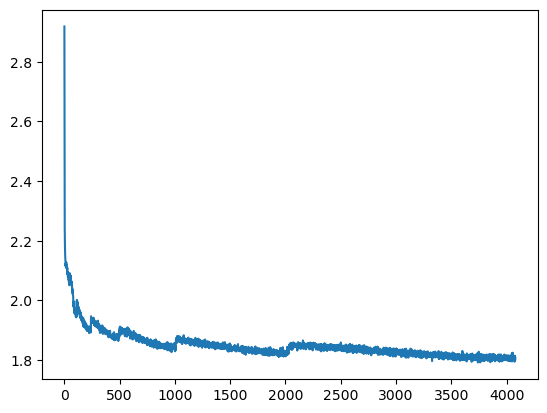

In [103]:
plt.plot(np.arange(len(Train)),Train)

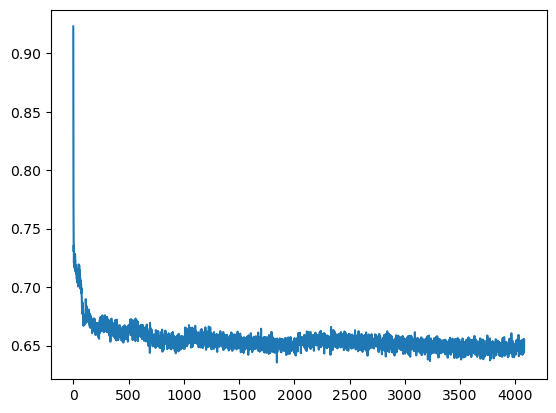

In [104]:
plt.plot(np.arange(len(Eval)),Eval)

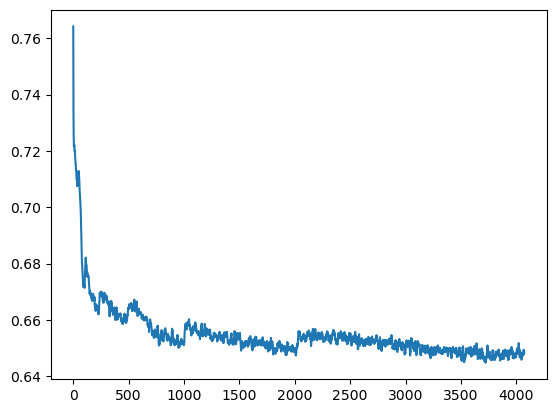

In [105]:
N = 10 #moving average
smothed_Eval = np.convolve(Eval, np.ones(N)/N, mode='valid')
plt.plot(np.arange(len(smothed_Eval)),smothed_Eval)

In [106]:
fname = "models/state_6L_RowAtt.pth" 
SCORES = eval_model(fname,train_dataloader,test_dataloader,val_dataloader)

EVALUATING ON TRAIN DATA : 
score_train = 0.6473856568336487

EVALUATING ON TEST DATA : 
score_test = 0.6523962616920471

EVALUATING ON VAL DATA : 
score_val = 0.6473610997200012



EVALUATING ON TRAIN DATA : 


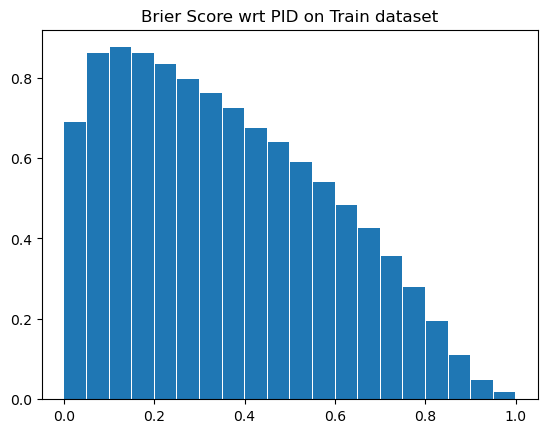

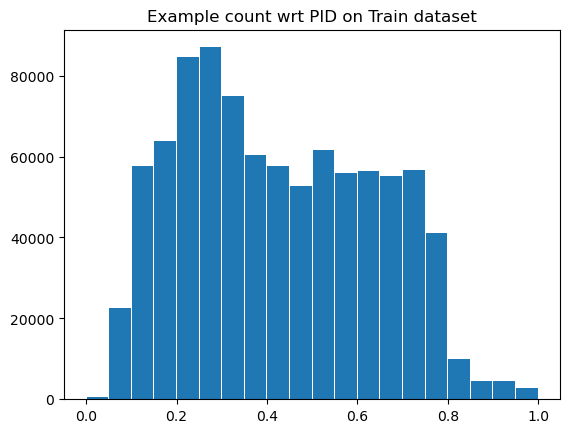

EVALUATING ON TEST DATA : 


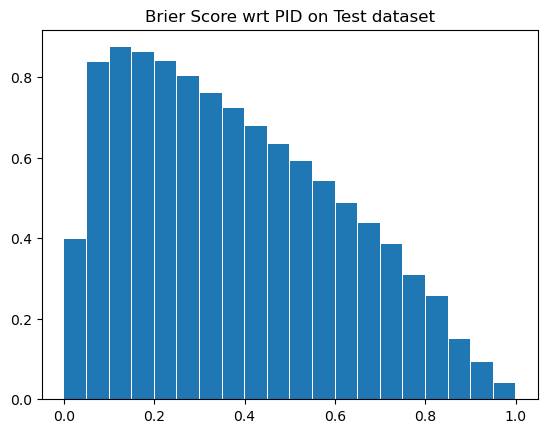

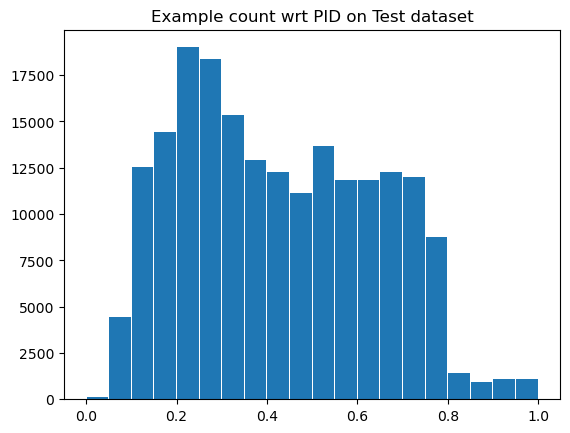

EVALUATING ON VAL DATA : 


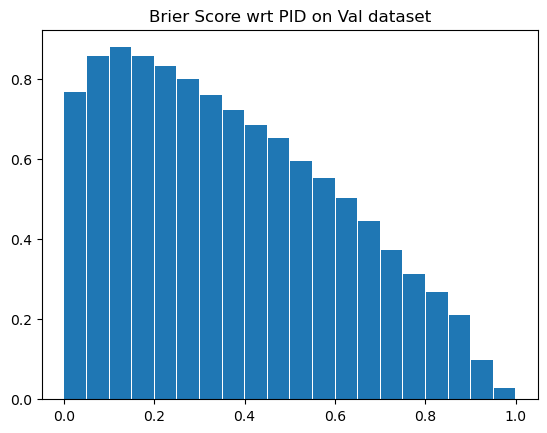

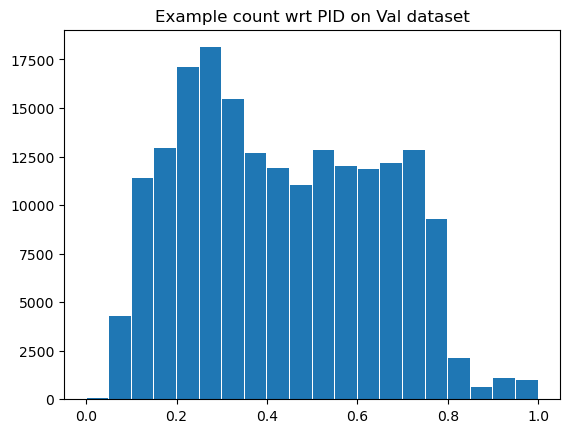

In [107]:
fname = "models/state_6L_RowAtt.pth" 
SCORES = eval_model_PID(fname,train_dataloader,test_dataloader,val_dataloader)

EVALUATING ON TRAIN DATA : 


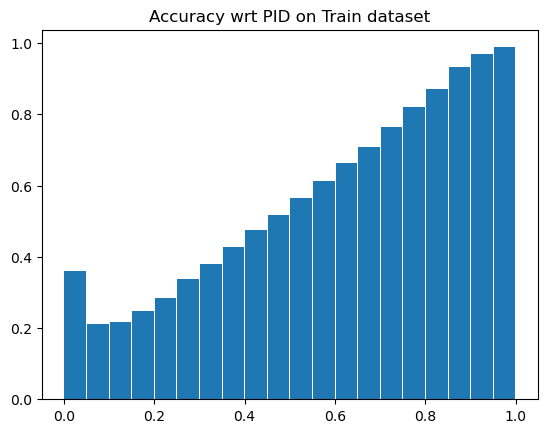

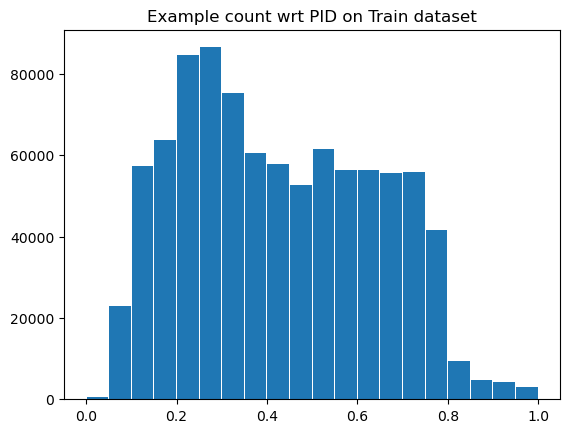

EVALUATING ON TEST DATA : 


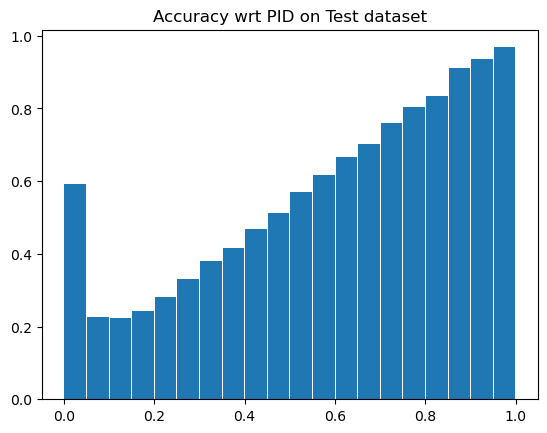

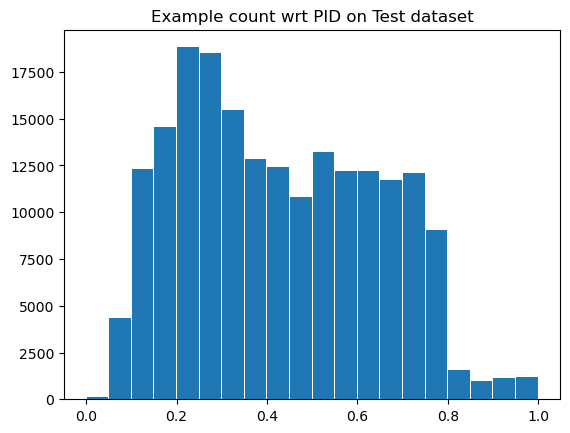

EVALUATING ON VAL DATA : 


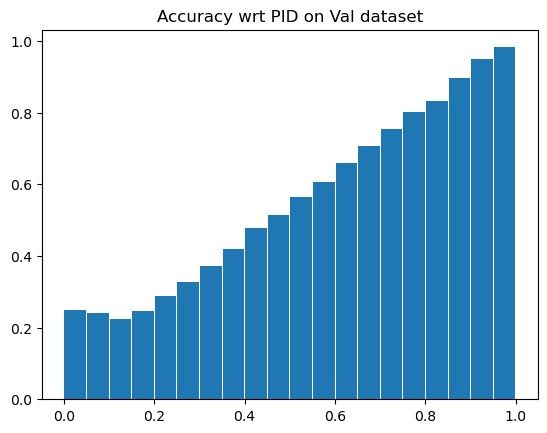

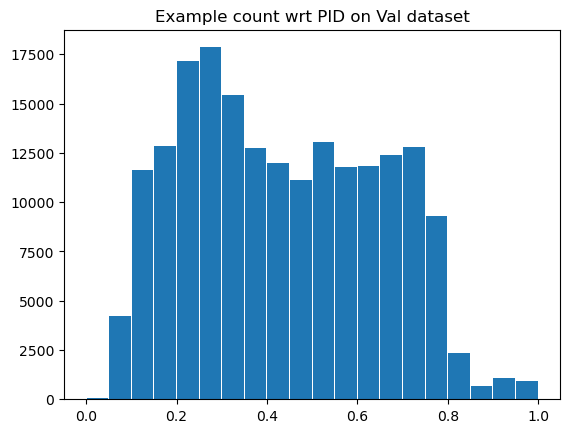

In [108]:
fname = "models/state_6L_RowAtt.pth" 
SCORES = eval_model_acc_PID(fname,train_dataloader,test_dataloader,val_dataloader)

In [60]:
fname = "models/state_6L_RowAtt.pth" 
savepath = Path(fname)
with savepath.open("rb") as fp:
    model = torch.load(fp).model.to('cpu').eval()

In [61]:
for X,y,PID,lPID,pfreqs,lpfreqs,pos,length in test_dataloader:
    break

In [62]:
X_input = model.to_input(X,PID,pfreqs,lpfreqs,pos,length)

In [134]:
idx = 42
L = [X_input.detach().cpu()]
x = X_input
for i,f in model.feature_extractor.named_children():
    x = f(x)
    L.append(x.detach().cpu())

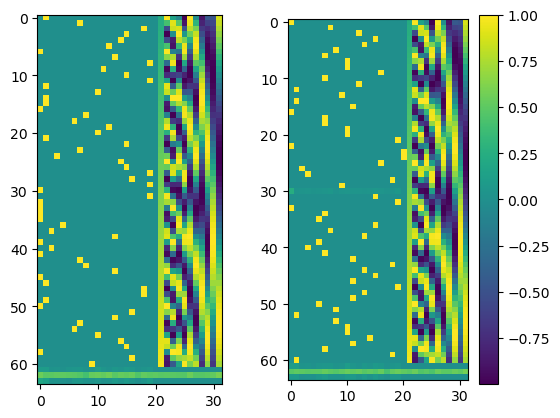

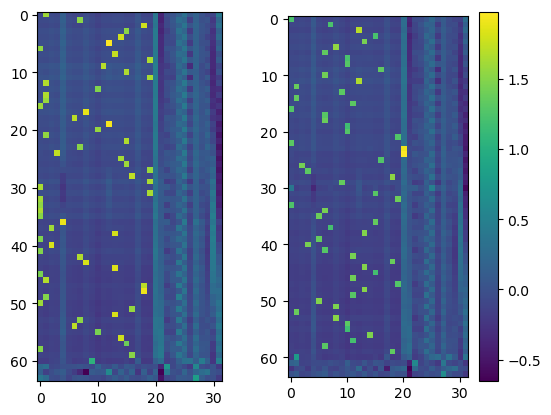

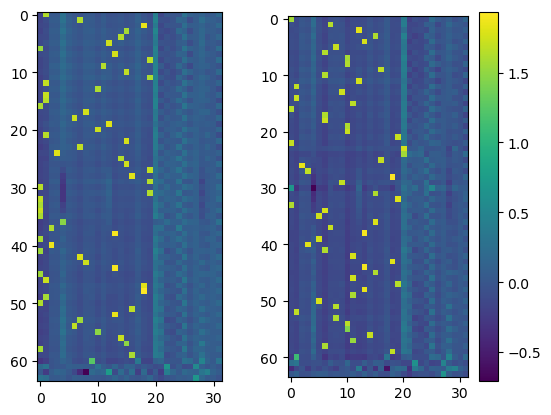

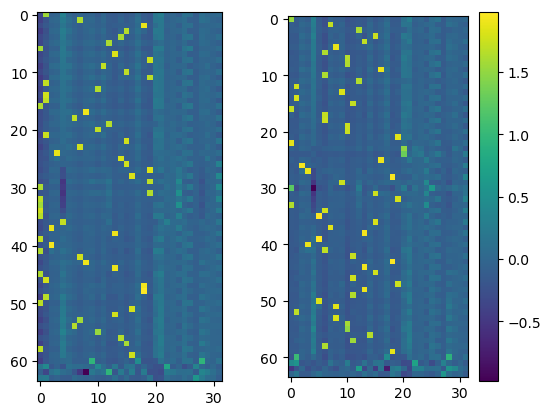

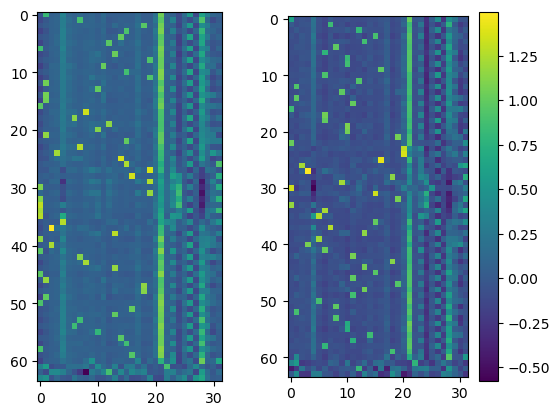

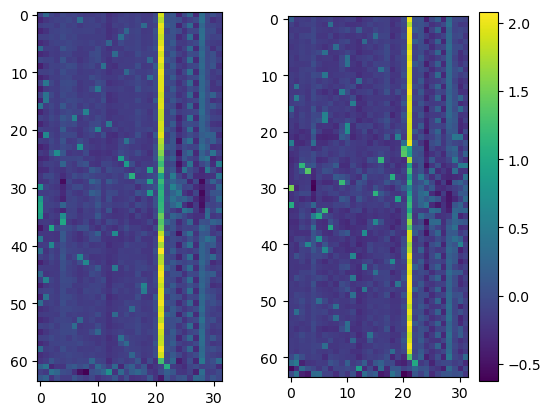

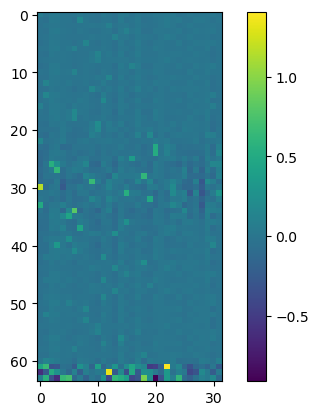

In [135]:
for X in L[:-1]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    im = ax1.imshow(X[idx][0])
    im = ax2.imshow(X[idx][1])
    fig.colorbar(im)
    plt.show()

plt.imshow(L[-1][idx])
plt.colorbar()
plt.show()

In [136]:
torch.argmax(L[-1][idx][30])

tensor(0)

In [137]:
y[idx]

tensor(18)

In [138]:
L[-1][idx][30][y[idx]]

tensor(-0.0950)

In [139]:
max(L[-1][idx][30])

tensor(1.1550)

In [147]:
y_pred = model.clf(L[-1][idx])
y_pred

tensor([[ 1.3535e+00,  7.0588e-01, -1.4436e+00, -1.4628e+00,  3.0706e-01,
          2.0719e-01, -4.3822e-01, -2.6805e-01, -1.4275e+00, -1.3213e-01,
          1.9992e-01, -5.8378e-02, -1.5179e+00,  2.0728e-04, -9.1204e-01,
          5.0222e-01, -9.0243e-01, -1.9706e+00,  1.9866e-01,  6.8377e-01]],
       grad_fn=<AddmmBackward0>)

In [149]:
y_pred[0][torch.argmax(X_input[idx][0][30])]

tensor(1.3535, grad_fn=<SelectBackward0>)

In [150]:
y_pred[0][y[idx]]

tensor(0.1987, grad_fn=<SelectBackward0>)

In [141]:
torch.argmax(X_input[idx][0][30])

tensor(0)